# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

## Notebook 2: Applying Reinforcement Learning to the Problem
If you have not already read through and tested out the network setup, please take some time to do so. It will provide you with the necessary background to understand the problem.

The purpose of this notebook is to implement a reinforcement learning algorithm using our network environment code. This allows us to train reinforcement learning algorithms. We modified [Laura D'Arcy's GraphRLnx repository](https://github.com/lauradarcy/graphRLnx) to create this class.

Please refer to the `tutorials/` folder for an overview of reinforcement learning. Essentially, we wish for our algorithm to learn the optimal path(s) from the source to the destination. We start by sending packets through the network randomly; we then use a function to see if the transmission was 'corrupted' in the way that we have previously defined it. We also take into consideration the number of hops the path takes. We adjust our incentive structure accordingly and, over time, the algorithm will learn what paths are optimal.

The specific algorithm we have implemented in this notebook is Q-learning. (add more overview)

**Note:** If you get any errors due to packages not being installed, please add them to the cell below. We might have not encountered these errors due to already having those packages installed on our computers for other courses/projects/etc.

In [1]:
!pip3 install gym

In [2]:
import gym
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from gym import spaces

Here we incorporate everything from the first notebook into a `graphRL` class. This class uses the `gym` environment template, which allows for training of RL algorithms.

In [25]:
class graphRL(gym.Env):  
    def random_edge(self):
        edges = list(self.graph.edges)
        nonedges = list(nx.non_edges(self.graph))
        if len(edges) > 0:
            chosen_edge = random.choice(edges)
            chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
        else:
            chosen_nonedge = random.choice(nonedges)
        self.graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
        
    def is_corrupted(self, path, verbose=False): 
        for node in path:
            attack_prob = self.devices[node].attack_prob
            attacked = random.uniform(0,1) < attack_prob
            if attacked:
                if verbose:
                    print('Node = ', node)
                return True
        return False

    def __init__(self, fname=None, network_size=10, edge_prob=1, percent_mal=0, attack_probs=[0, 0]):
        self.devices = []
        self.mal_nodes = []
        
        class device:
            pass

        if fname != None:
            with open(fname) as f:
                lines = [line.rstrip() for line in f]

                self.network_size = int(lines[0])
                self.src = 0
                self.dst = self.network_size - 1
                
                edges = [eval(x) for x in lines[1:-1]]
                self.graph = nx.Graph()
                self.graph.add_nodes_from(list(range(network_size)))
                self.graph.add_edges_from(edges)
                
                attack_probs = [float(x) for x in lines[-1].split(',')]
                
                nodes = list(range(0, self.network_size))
                
                for node, prob in zip(nodes, attack_probs):
                    a = device()
                    a.node = node
                    a.attack_prob = prob
                    
                    if prob > 0:
                        self.mal_nodes.append(node)
                        a.mal = True
                    
                    else:
                        a.mal = False
                        
                    self.devices.append(a)
        
        else:
            self.network_size = network_size
            self.src = 0
            self.dst = network_size - 1

            self.graph = nx.gnp_random_graph(network_size, edge_prob)
            while not nx.is_connected(self.graph):
                self.random_edge()

            num_mal = network_size * percent_mal

            while num_mal > 0:
                rand = np.random.randint(0, network_size)           
                if rand != src and rand != dst and rand not in self.mal_nodes:
                    self.mal_nodes.append(rand)
                    num_mal -= 1

            nodes = list(range(0, network_size))

            for node in nodes:
                a = device()
                a.node = node

                if node in self.mal_nodes:
                    a.mal = True
                    a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
                else:
                    a.mal = False
                    a.attack_prob = 0

                self.devices.append(a)
            
        self.num_actions = network_size
        self.num_states  = network_size
            
        self.action_space = spaces.Discrete(self.num_actions)                   
        self.observation_space = spaces.Discrete(self.num_states)
        
        self.reset()

    def render(self):
        nx.draw(self.graph, with_labels=True)
        plt.show()

    def step(self, action):
        done = 0
        reward = 0
        assert self.action_space.contains(action)
        
        reward -= 1 # 
        
#         if self.is_corrupted(action):
#             reward -= corrupted_node_penalty
        
        self.time_step += 1
        return action, reward, done, {"time_step": self.time_step}

    def reset(self):
        self.time_step = 0
        self.observation = nx.to_numpy_matrix(self.graph).astype(int) # I'm not sure if this is needed
        return self.observation

We create an instance of the graphRL class and render it. As a reminder of our convention, the source node is always Node 0 and the destination node is the highest numbered node. Additionally, we print out all of the nodes and whether they are malicious. This will help us confirm that our algorithm is learning to avoid the malicious nodes. By visual inspection, we can also confirm that our algorithm is learning the shortest paths from source to destination.

Node 0 is NOT malicious.
Node 1 is NOT malicious.
Node 2 is NOT malicious.
Node 3 IS malicious. Attack probability is 0.64.
Node 4 is NOT malicious.
Node 5 IS malicious. Attack probability is 0.85.
Node 6 is NOT malicious.
Node 7 is NOT malicious.
Node 8 is NOT malicious.
Node 9 is NOT malicious.


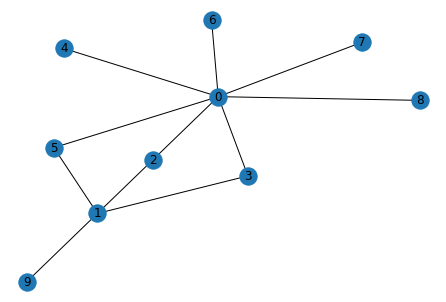

In [26]:
# env = graphRL(network_size=10, edge_prob=0.1, percent_mal=0.4, attack_probs=[0.3, 0.8])
env = graphRL('./env/env1.txt')

for a in env.devices:
    if a.mal:
        print(f'Node {a.node} IS malicious. Attack probability is {a.attack_prob:.2f}.')
    else:
        print(f'Node {a.node} is NOT malicious.')
        
env.render()

Some hyperparameters we introduce when we move to a RL environment:
* `corrupted_node_penalty` refers to the penalty our algorithm incurs when it encounters a corrupted node.
* `dead_end_penalty` refers to the penalty our algorithm incurs when it encounters a dead-end node. We don't need to consider this node for future pathfinding, so we put an enormous penalty on it.

The other hyperparameters are used for the Q-learning algorithm (definitions used from the [RL tutorial source](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)):
* `alpha` is the learning rate (0 < $\alpha$ <= 1). This captures the extent to which the Q-values are updated from one training iteration.
* `gamma` is the discount factor (0 < $\gamma$ <= 1). $\gamma$ determines how much importance we want to give to future rewards. A lower $\gamma$ makes our algorithm consider immediate rewards more, while a higher $\gamma$ captures a long-term effective reward.
* `epsilon` is the degree (0 < $\epsilon$ <= 1) to which we want to explore the action space (i.e. pick a random value) or exploit our learned Q-values. A lower $\epsilon$ will result in more penalties during training because we are more often picking new, unexplored paths. A higher $\epsilon$ will result in fewer penalties during training but may lead to overfitting.

In [27]:
q_table = np.zeros([env.num_states, env.num_actions])

corrupted_path_penalty = 10
clean_path_reward = corrupted_path_penalty # Is this something to have? 
dead_end_penalty = 1000 # Continue working on this 
# Node: don't want this to be np.inf because it will fail in some edge cases (since invalid neighbors are np.inf)

alpha = 0.1
gamma = 0.6
epsilon = 0.1

In [28]:
VISITED = -1

# For plotting metrics
all_epochs = []
all_penalties = []

# Number of training iterations
for i in range(1, 100001):
    total_penalty = 0
    path = []
    state = env.src

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    visit_arr = np.zeros(network_size) # 
    
    while not done:
        path.append(state)
        dead_end = True
        visit_arr[state] = VISITED # Shows that we have visited a node
        
        valid_neighbors = list(env.graph.neighbors(state)) # These are the valid possible actions
        
        # Check to see if the node is a dead end
        for neighbor in valid_neighbors:
            if visit_arr[neighbor] != VISITED:
                dead_end = False
        
        # This node is a dead end, so we put a giant penalty on it so we don't go to it again in future iterations
        if dead_end:
            q_table[:, state] = -dead_end_penalty 
            done = True

        # The node is not a dead end, so we continue trying to find paths to the destination
        else:  
            # Explore the action space
            # We have to make sure the selected action is valid, but otherwise we are picking a random action
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
                while action not in valid_neighbors or visit_arr[action] == VISITED: # 
                    action = env.action_space.sample()
            
            # Exploit learned values
            # We have to make sure the selected action is valid, but otherwise we are picking the action with the highest Q-value
            else:
                slc = q_table[state]
                action = np.argmax(slc)               

                while action not in valid_neighbors or visit_arr[action] == VISITED:
                    slc[action] = -np.Inf
                    action = np.argmax(slc)

            next_state, reward, done, info = env.step(action)  # keep track of total reward

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state

            if state == env.dst:
                path.append(state)
                done = True
                
            total_penalty += 1 # += reward
            epochs += 1
            
    if dead_end == True:
        print(f'Path taken = {path}. Encountered a dead end.')
    else:
        print(f'Path taken = {path}.')
        
        if env.is_corrupted(path): # hash
            for node in path[1:len(path)-2]: #
                q_table[:, node] -= corrupted_path_penalty / len(path)
            total_penalty += corrupted_path_penalty
            print(f'This path was corrupted.')
            
        ## Is this necessary? 
        else:
            for node in path[1:len(path)-2]:
                q_table[:, node] += clean_path_reward / len(path)
            
    all_epochs.append(i)
    all_penalties.append(total_penalty)
        
    if i % 100 == 0:
        #clear_output(wait=True)
        print(f"Episode: {i}")

Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].


Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken =

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].

Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = 

Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 8]. Encountered a dead 

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path w

Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was co

This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
P

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was c

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 4600
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupte

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 5100
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken =

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 5400
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1,

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Episode: 6800
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken =

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 8700
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path t

Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 10000
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Pat

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 10700
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].


Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 11300
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 5

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1

Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [

This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was c

Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a d

Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 18400
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Thi

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 19000
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Episode: 20000
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken 

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = 

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corr

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0,

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 21800
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [

Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupte

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 24000
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1,

Path taken = [0, 5, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path tak

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0,

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was c

Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corr

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 26900
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken 

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was c

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path 

Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 30500
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9]

Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 31100
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
P

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a 

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 32500
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path

This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 33300
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path ta

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path 

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 34800
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1,

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9]

This path was corrupted.
Episode: 35900
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
This pat

Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5

Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 38200
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9]

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Episode: 39600
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0

Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
P

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1

Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 7]. Encountered a dead end.
Episode: 42400
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This pa

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Pat

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path ta

Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This pat

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was 

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = 

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Episode: 46500
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken =

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This pa

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path tak

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Thi

This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 50400
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This pat

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountere

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corru

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 52300
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1,

This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 52800
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead e

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path 

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].


This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
P

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Episode: 57800
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
P

Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 6]. Encountered a 

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This p

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 59700
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 

Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path 

Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountere

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corru

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Pa

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This pa

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 64300
P

This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Pat

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 67200
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path t

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path 

Path taken = [0, 3, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Episode: 70500
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken 

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 71200
Path taken = [0, 3, 1, 2]. Encountered a de

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken =

Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path ta

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path

Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 73400
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path take

This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Th

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Episode: 74900
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.


Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 76000
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0

Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Episode: 76600
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This p

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken 

This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path wa

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path t

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was co

This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was cor

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was 

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. E

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encounter

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 84000
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path t

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 84800
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1,

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1,

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This pat

Path taken = [0, 2, 1, 9].
Episode: 86800
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path ta

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path t

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].

This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken =

Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 89300
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path tak

Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 90400
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path ta

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corr

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path wa

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 92400
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Episode: 93100
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupt

Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = 

Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0,

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].


Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 95700
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
Path taken = [0, 5

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 5, 1, 3]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path

This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 5, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 2, 1, 9].
Path taken = [0, 3, 1, 9].
Path taken

Episode: 98200
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9]

Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Episode: 99200
Path taken = [0, 2, 1, 5]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 8]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 4]. Encountered a dead end.
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0, 2, 1, 9].
Path taken = [0,

Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 7]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 2]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 5, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Episode: 99900
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].
Path taken = [0, 3, 1, 5]. Encountered a dead end.
Path taken = [0, 3, 1, 9].
This path was corrupted.
Path taken = [0, 3, 1, 9].


In [29]:
import pandas as pd

print(pd.DataFrame(q_table))

     0           1       2            3       4       5       6       7  \
0 -inf        -inf -1000.0   -15.383443 -1000.0 -1000.0 -1000.0 -1000.0   
1 -inf        -inf -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
2 -inf  283.913914 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
3 -inf   -1.600000 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
4  0.0    0.000000 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
5 -inf  115.302753 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
6  0.0    0.000000 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
7  0.0    0.000000 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
8  0.0    0.000000 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   
9  0.0    0.000000 -1000.0 -1390.000000 -1000.0 -1000.0 -1000.0 -1000.0   

        8    9  
0 -1000.0 -inf  
1 -1000.0 -1.0  
2 -1000.0 -inf  
3 -1000.0 -inf  
4 -1000.0  0.0  
5 -1000.0 -inf  
6 -1000.0  0.0  
7 -1000.0  0.0  
8 -1000.0  0.0  
9 -1

In [18]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

AssertionError: 